In [1]:
import pandas as pd
from sklearn import model_selection, preprocessing
from sklearn import tree, linear_model, svm, ensemble, metrics
import matplotlib
from matplotlib import pyplot as plt
import xgboost as xgb
import scipy
import numpy as np
from pprint import pprint as pp

import compare_y
import cross_validation_result as cvr
import ML_helper

%matplotlib inline

In [2]:
def PSL_result(subsets=[], psl_types=[], legends=[], scaling="percent", title=""):
    truth_folder = "../psl/data/master_data_{0}/{1}_overlap/".format(scaling, "_".join(subsets))
    INFER = "../psl/result/{0}_overlap/{1}/"
    matrix_file = "../data/data_table_{0}_{1}_overlap.tsv".format(scaling, "_".join(subsets))

    Classifiers = {#"XGBoost": xgb.XGBRegressor(n_estimators=100),
                   "Linear Regression": linear_model.LinearRegression()
                  }

    results = {"mse": {"mean": pd.DataFrame(), "error": pd.DataFrame(index=[0])},
               "rho": {"mean": pd.DataFrame(), "error": pd.DataFrame(index=[0])}}

    for psl_type in psl_types:
        infer_folder = INFER.format("_".join(subsets), psl_type)
        PSL_accus = cvr.cross_val_result(truth_folder, infer_folder)        
        for accu_type, accu in {"mse": PSL_accus[0], "rho": PSL_accus[1]}.iteritems():
            results[accu_type]["mean"].set_value(accu_type, psl_type, np.mean(accu))
            results[accu_type]["error"].set_value(accu_type, psl_type, np.std(accu))
            
    X, Y = ML_helper.load_data(matrix_file)
    #X = preprocessing.PolynomialFeatures(2).fit_transform(X)
    ML_accus = ML_helper.run_cross_val(X, Y, Classifiers, n_fold=6)
    for accu_type, accu in {"mse": ML_accus[0], "rho": ML_accus[1]}.iteritems():
        for algo in Classifiers.keys():
            results[accu_type]["mean"].set_value(accu_type, algo, accu[algo].mean())
            results[accu_type]["error"].set_value(accu_type, algo, accu[algo].std())

    # plotting
    f, ax = plt.subplots(2, 1, figsize=(6,9))
    ylims = {0: (-0.05,0.2), 1:(-0.1, 1.1)}
    for idx, accu_type in enumerate(["mse", "rho"]):
        results[accu_type]["mean"].plot.bar(ax=ax[idx], yerr=results[accu_type]["error"], 
                                            fontsize=15, rot=0)
        ax[idx].set_ylabel(accu_type, fontsize=15)
        ax[idx].legend(legends + ["Linear Regression"], loc='best', bbox_to_anchor=(1.0, 0.9), fontsize=15)
    ax[0].set_title(title, fontsize=15)

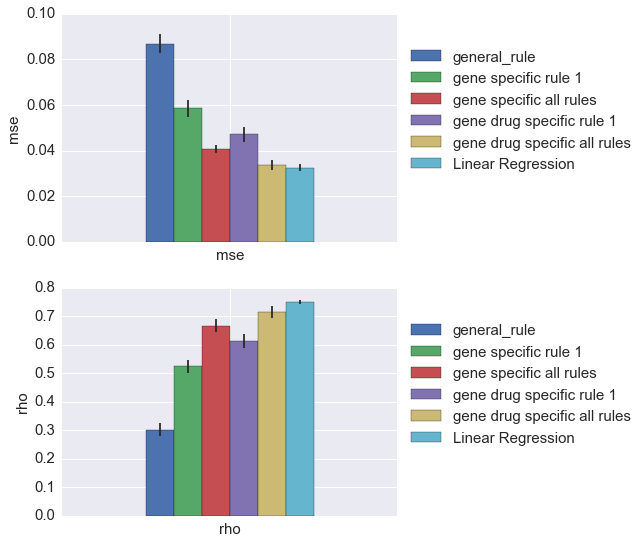

In [9]:
to_plot = [
"general_rule",
"rule_swapping_experiment/gene_specific_rule_and_not_sensitive_prior",
"rule_swapping_experiment/all_rules",
"gene_drug_specific_rule_weight_1_iters_100_lr_10",
"gene_drug_specific_rule_all_rules",        

]

legends = ["general_rule",
           "gene specific rule 1", 
           "gene specific all rules",
           "gene drug specific rule 1", 
           "gene drug specific all rules"]



PSL_result(subsets=["essential"], psl_types=to_plot, legends=legends)

# Number of parameters in above plot:
#### ML: 154
#### PSL_gene_specific_rule: 78
#### PSL_gene_drug_specific_rule: 22 * 77 + 1 = 1695